In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import expit
from scipy import optimize

# Clasificador de calidad de microchips
Disponemos de una base de datos con la calificacion de calidad de diferentes chips, analizaremos los datos, y decidiremos si un chip es admitido para lanzar al mercado o no. Ademas ajustaremos hiper-parametros para conseguir diferentes resultados

#### 2.1 Visualizar la data

In [22]:
datafile = 'ex2data2.txt'
#Se importan los datos
cols = np.loadtxt(datafile,delimiter=',',usecols=(0,1,2),unpack=True) #Read in comma separated data
##Matriz x, matriz y
X = np.transpose(np.array(cols[:-1]))
y = np.transpose(np.array(cols[-1:]))
#Numero de entradas
m = y.size
#Se le agrega la columna de 1's a X
X = np.insert(X,0,1,axis=1)

In [23]:
#Dividir los datos entre los admitidos y los rechazados
adm = np.array([X[i] for i in range(X.shape[0]) if y[i] == 1])
noAdm = np.array([X[i] for i in range(X.shape[0]) if y[i] == 0])

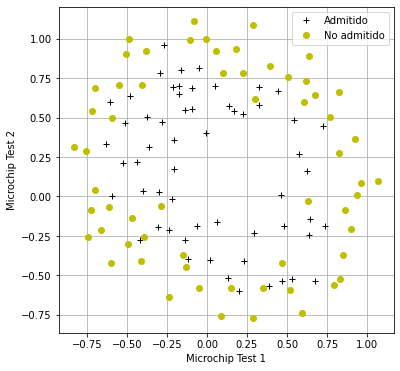

In [24]:
def plotData():
    plt.plot(adm[:,1],adm[:,2],'k+',label='Admitido')
    plt.plot(noAdm[:,1],noAdm[:,2],'yo',label='No admitido')
    plt.xlabel('Microchip Test 1')
    plt.ylabel('Microchip Test 2')
    plt.legend()
    plt.grid(True)

plt.figure(figsize=(6,6))
plotData()

#### 2.2 Feature mapping

In [25]:
#El codigo toma X para formar una matriz de 28 elementos, conocido como "mapping":
#El mapping aumenta el numero de caracteristicas, para lograr un modelo que se ajuste mejor a los datos.
#Esto se consigue creando mayor cantidad de variables independientes, elevando a potencias (en este caso de 6) 
#las variables ya existentes. 
#Esta practica puede llevar al modelo a "overfitting", que se corrige ajustando lambda.

def mapFeature( x1col, x2col ):
    """ 
    Funcion que toma las columnas de X y las procesa elevandolas hasta la sexta potencia
    para formar una matriz de 28 columnas
    """
    degrees = 6
    out = np.ones((x1col.shape[0], 1))

    for i in range(1, degrees+1):
        for j in range(0, i+1):
            term1 = x1col ** (i-j)
            term2 = x2col ** (j)
            term  = (term1 * term2).reshape( term1.shape[0], 1 ) 
            out   = np.hstack(( out, term ))
    return out

In [26]:
#Ejecuto la regularizacion
mappedX = mapFeature(X[:,1],X[:,2])

#### 2.3 Cost function and gradient

In [27]:
#Funcion hipotesis (H) y funcion de costo (J)
def h(mytheta,myX): 
    return expit(np.dot(myX,mytheta))

def computeCost(mytheta,myX,myy,mylambda = 0.): 
    """
    X matriz de n-filas y m-columnas
    theta es una matriz de m-filas y 1 columna
    y es una matrix with m-filas y una columna
    Note: esta funcion incluye lambda, que sera utilizado para regularizar la funcion,
    se usara en la segunda parte de la presentación
    """
    term1 = np.dot(-np.array(myy).T,np.log(h(mytheta,myX)))
    term2 = np.dot((1-np.array(myy)).T,np.log(1-h(mytheta,myX)))
    regterm = (mylambda/2) * np.sum(np.dot(mytheta[1:].T,mytheta[1:]))
    #term1 y term2 son matrices 1x1, por eso np.sum
    J = float((1./m) * (np.sum(term1 - term2) + regterm))  
    return J

In [28]:
#La funcion de costo es la misma de la parte 1
#Theta inicial ahora es una matriz de 28 columnas
#Verficar que J = 0.693 para theta = 0
initial_theta = np.zeros((mappedX.shape[1],1))
computeCost(initial_theta,mappedX,y)

0.6931471805599454

##### 2.3.1 Learning parameters using fminunc

In [29]:
def optimizeRegularizedTheta(mytheta,myX,myy,mylambda=0.):
    result = optimize.minimize(computeCost, mytheta, args=(myX, myy, mylambda),  
                               method='BFGS', options={"maxiter":500, "disp":False})
    return np.array([result.x]), result.fun
    
theta, mincost = optimizeRegularizedTheta(initial_theta,mappedX,y)

#### 2.4 Plotting the decision boundary

In [30]:
def plotBoundary(mytheta, myX, myy, mylambda=0.):
    """
    Funcion que grafica "decision boundary" con X,y y theta evaluados
    Dentro de la funcion misma, se mapea X y se calculan los thetas minimos, teniendo en cuenta lambda
    Funciona con x1 ("xvals") y x2 ("yvals") como puntos,
    Y para cada punto la funcion calcula si es True o False
    """
    theta, mincost = optimizeRegularizedTheta(mytheta,myX,myy,mylambda)
    xvals = np.linspace(-1,1.5,50)
    yvals = np.linspace(-1,1.5,50)
    zvals = np.zeros((len(xvals),len(yvals)))
    for i in range(len(xvals)):
        for j in range(len(yvals)):
            myfeaturesij = mapFeature(np.array([xvals[i]]),np.array([yvals[j]]))
            zvals[i][j] = np.dot(theta,myfeaturesij.T)
    zvals = zvals.transpose()
    u, v = np.meshgrid( xvals, yvals )
    mycontour = plt.contour( xvals, yvals, zvals, [0])
    
    #Texto sobre la "decision boundary"
    myfmt = { 0:'Lambda = %d'%mylambda}
    plt.clabel(mycontour, inline=1, fontsize=15, fmt=myfmt)

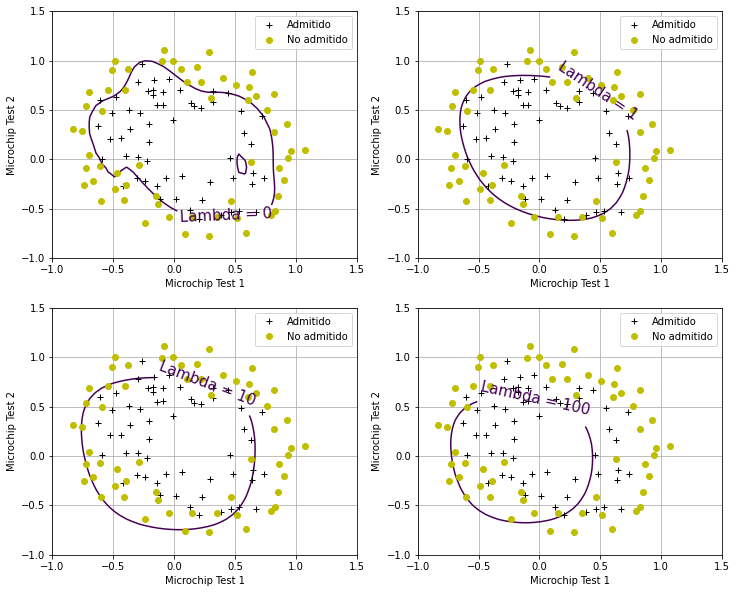

In [31]:
#Graficamos distintos "decision boundary" con sus respectivos lambdas
#Se ve que con lambda=0 el modelo esta "overfitting", y en lambda=100 esta "underfitting"
plt.figure(figsize=(12,10))

plt.subplot(221)
plotData()
plotBoundary(theta,mappedX,y,0.)

plt.subplot(222)
plotData()
plotBoundary(theta,mappedX,y,1)

plt.subplot(223)
plotData()
plotBoundary(theta,mappedX,y,10.)

plt.subplot(224)
plotData()
plotBoundary(theta,mappedX,y,100.)